In [12]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, balanced_accuracy_score,
    roc_auc_score, average_precision_score, matthews_corrcoef,
    precision_score, recall_score, f1_score, accuracy_score
)
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

print("All packages imported successfully!")

All packages imported successfully!


In [13]:
# %%
# Load your dataset here
# data = pd.read_csv('your_dataset.csv')

# For demonstration - creating sample imbalanced data
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=10000, n_features=20, n_informative=15,
    n_redundant=5, n_clusters_per_class=1,
    weights=[0.99, 0.01], random_state=42
)

feature_columns = [f'V{i+1}' for i in range(20)]
data = pd.DataFrame(X, columns=feature_columns)
data['Class'] = y

print("Dataset shape:", data.shape)
print("\nClass distribution:")
print(data['Class'].value_counts())
print(f"Fraud percentage: {data['Class'].mean():.4f}")

Dataset shape: (10000, 21)

Class distribution:
Class
0    9861
1     139
Name: count, dtype: int64
Fraud percentage: 0.0139


In [14]:
# %%
X = data.drop("Class", axis=1)
y = data["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nTraining set class distribution:")
print(y_train.value_counts())
print("\nTest set class distribution:")
print(y_test.value_counts())

Training set shape: (8000, 20)
Test set shape: (2000, 20)

Training set class distribution:
Class
0    7889
1     111
Name: count, dtype: int64

Test set class distribution:
Class
0    1972
1      28
Name: count, dtype: int64


In [15]:
# %%
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print("After Random UnderSampling:")
print("Resampled training set shape:", X_resampled.shape)
print("Resampled class distribution:")
print(pd.Series(y_resampled).value_counts())

After Random UnderSampling:
Resampled training set shape: (222, 20)
Resampled class distribution:
Class
0    111
1    111
Name: count, dtype: int64


In [16]:
# %%
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_resampled, y_resampled)
    trained_models[name] = model
    print(f"✓ {name} trained successfully!\n")

Training Decision Tree...
✓ Decision Tree trained successfully!

Training Random Forest...
✓ Random Forest trained successfully!

Training Logistic Regression...
✓ Logistic Regression trained successfully!

Training SVM...
✓ SVM trained successfully!

Training XGBoost...
✓ XGBoost trained successfully!



In [17]:
# %%
def evaluate_model(model, X_test, y_test, model_name):
    """Comprehensive model evaluation with all required metrics"""

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()

    # Calculate all metrics
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Balanced_Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred),
        'F1_Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC_AUC': roc_auc_score(y_test, y_prob),
        'PR_AUC': average_precision_score(y_test, y_prob),
        'MCC': matthews_corrcoef(y_test, y_pred),
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN
    }

    # Cost-sensitive evaluation
    FP_cost = 1  # Cost of false positive
    FN_cost = 10  # Cost of false negative (usually higher for fraud)
    total_cost = FP * FP_cost + FN * FN_cost
    cost_savings = (FN_cost * y_test.sum() - total_cost)  # Potential savings

    metrics['Total_Cost'] = total_cost
    metrics['Cost_Savings'] = cost_savings
    metrics['Cost_Reduction_Percentage'] = (cost_savings / (FN_cost * y_test.sum())) * 100

    return metrics, cm

In [18]:
# %%
results = []
confusion_matrices = {}

print("Evaluating models with Random UnderSampling...")
print("=" * 60)

for model_name, model in trained_models.items():
    print(f"\nEvaluating {model_name}...")
    metrics, cm = evaluate_model(model, X_test, y_test, model_name)
    results.append(metrics)
    confusion_matrices[model_name] = cm

    # Print detailed results
    print(f"Balanced Accuracy: {metrics['Balanced_Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1-Score: {metrics['F1_Score']:.4f}")
    print(f"ROC AUC: {metrics['ROC_AUC']:.4f}")
    print(f"PR AUC: {metrics['PR_AUC']:.4f}")
    print(f"MCC: {metrics['MCC']:.4f}")
    print(f"Cost Savings: {metrics['Cost_Savings']:.2f}")
    print(f"Cost Reduction: {metrics['Cost_Reduction_Percentage']:.2f}%")
    print("-" * 40)

Evaluating models with Random UnderSampling...

Evaluating Decision Tree...
Balanced Accuracy: 0.6569
Precision: 0.0270
Recall: 0.6429
F1-Score: 0.0518
ROC AUC: 0.6569
PR AUC: 0.0223
MCC: 0.0782
Cost Savings: -469.00
Cost Reduction: -167.50%
----------------------------------------

Evaluating Random Forest...
Balanced Accuracy: 0.7905
Precision: 0.0707
Recall: 0.7143
F1-Score: 0.1286
ROC AUC: 0.8034
PR AUC: 0.2183
MCC: 0.1958
Cost Savings: -63.00
Cost Reduction: -22.50%
----------------------------------------

Evaluating Logistic Regression...
Balanced Accuracy: 0.7771
Precision: 0.0516
Recall: 0.7500
F1-Score: 0.0966
ROC AUC: 0.8180
PR AUC: 0.4686
MCC: 0.1617
Cost Savings: -176.00
Cost Reduction: -62.86%
----------------------------------------

Evaluating SVM...
Balanced Accuracy: 0.7806
Precision: 0.1006
Recall: 0.6429
F1-Score: 0.1739
ROC AUC: 0.8230
PR AUC: 0.2738
MCC: 0.2310
Cost Savings: 19.00
Cost Reduction: 6.79%
----------------------------------------

Evaluating XGBoost..

In [19]:
# %%
results_df = pd.DataFrame(results)
display_columns = ['Model', 'Balanced_Accuracy', 'Precision', 'Recall',
                  'F1_Score', 'ROC_AUC', 'PR_AUC', 'MCC', 'Cost_Savings', 'Cost_Reduction_Percentage']

print("COMPREHENSIVE RESULTS SUMMARY - Random UnderSampling")
print("=" * 80)
display(results_df[display_columns].round(4))

COMPREHENSIVE RESULTS SUMMARY - Random UnderSampling


,Model,Balanced_Accuracy,Precision,Recall,F1_Score,ROC_AUC,PR_AUC,MCC,Cost_Savings,Cost_Reduction_Percentage
0,Decision Tree,0.6569,0.0270,0.6429,0.0518,0.6569,0.0223,0.0782,-469,-167.5000
1,Random Forest,0.7905,0.0707,0.7143,0.1286,0.8034,0.2183,0.1958,-63,-22.5000
2,Logistic Regression,0.7771,0.0516,0.7500,0.0966,0.8180,0.4686,0.1617,-176,-62.8571
3,SVM,0.7806,0.1006,0.6429,0.1739,0.8230,0.2738,0.2310,19,6.7857
4,XGBoost,0.7571,0.0554,0.6786,0.1024,0.7948,0.3411,0.1603,-134,-47.8571


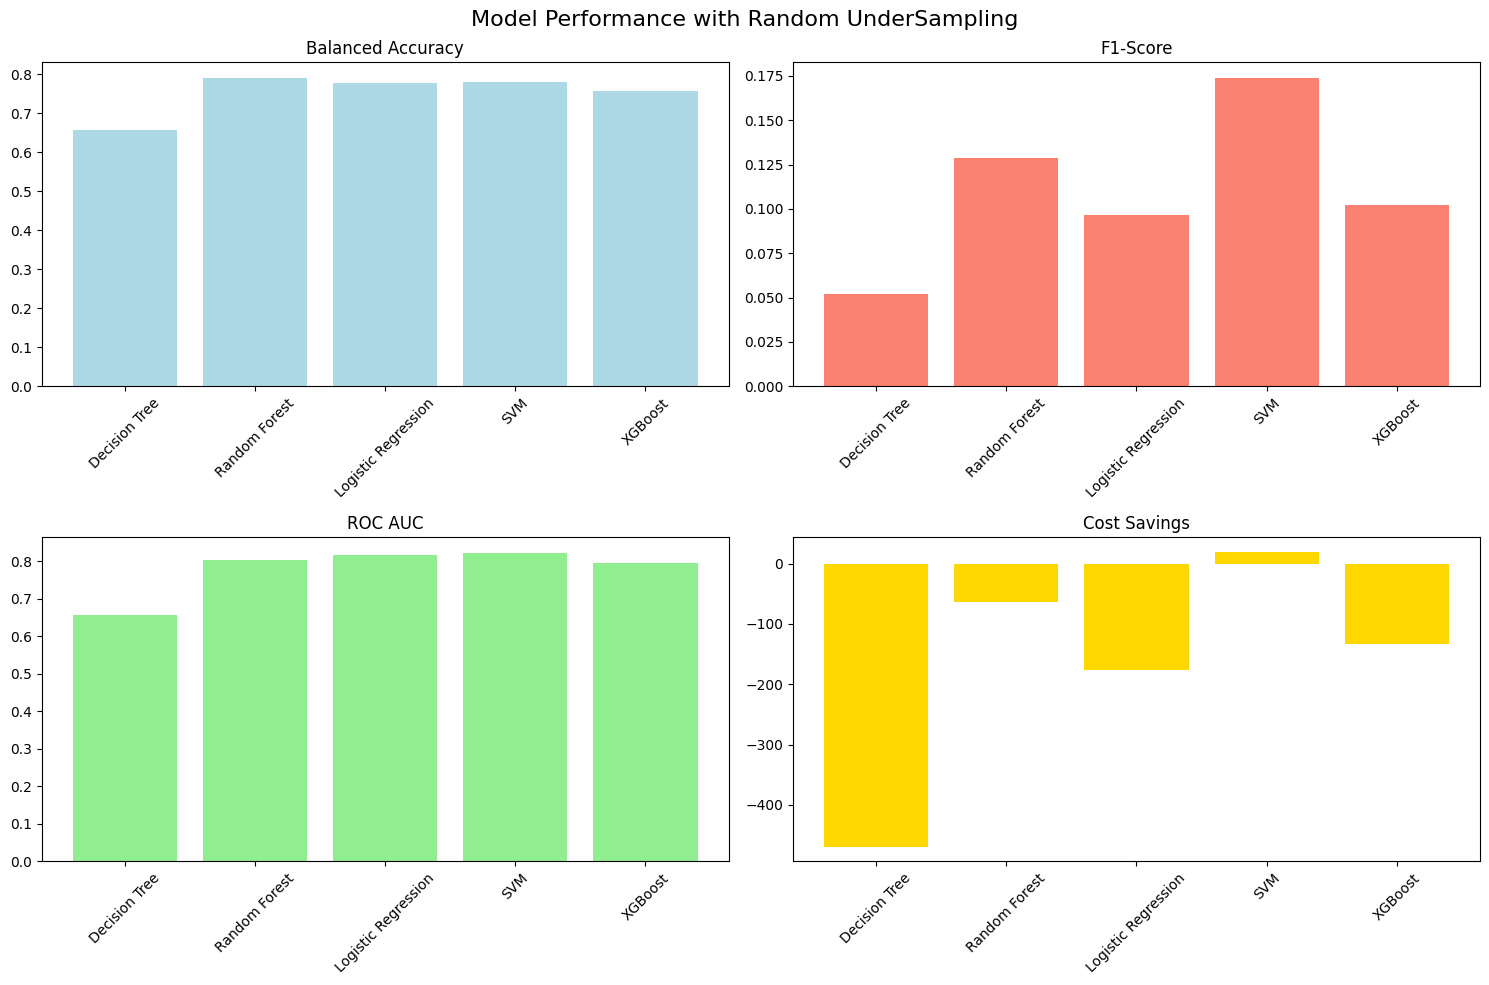

In [20]:
# %%
# Plot comparison of key metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance with Random UnderSampling', fontsize=16)

# Balanced Accuracy
axes[0,0].bar(results_df['Model'], results_df['Balanced_Accuracy'], color='lightblue')
axes[0,0].set_title('Balanced Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)

# F1-Score
axes[0,1].bar(results_df['Model'], results_df['F1_Score'], color='salmon')
axes[0,1].set_title('F1-Score')
axes[0,1].tick_params(axis='x', rotation=45)

# ROC AUC
axes[1,0].bar(results_df['Model'], results_df['ROC_AUC'], color='lightgreen')
axes[1,0].set_title('ROC AUC')
axes[1,0].tick_params(axis='x', rotation=45)

# Cost Savings
axes[1,1].bar(results_df['Model'], results_df['Cost_Savings'], color='gold')
axes[1,1].set_title('Cost Savings')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

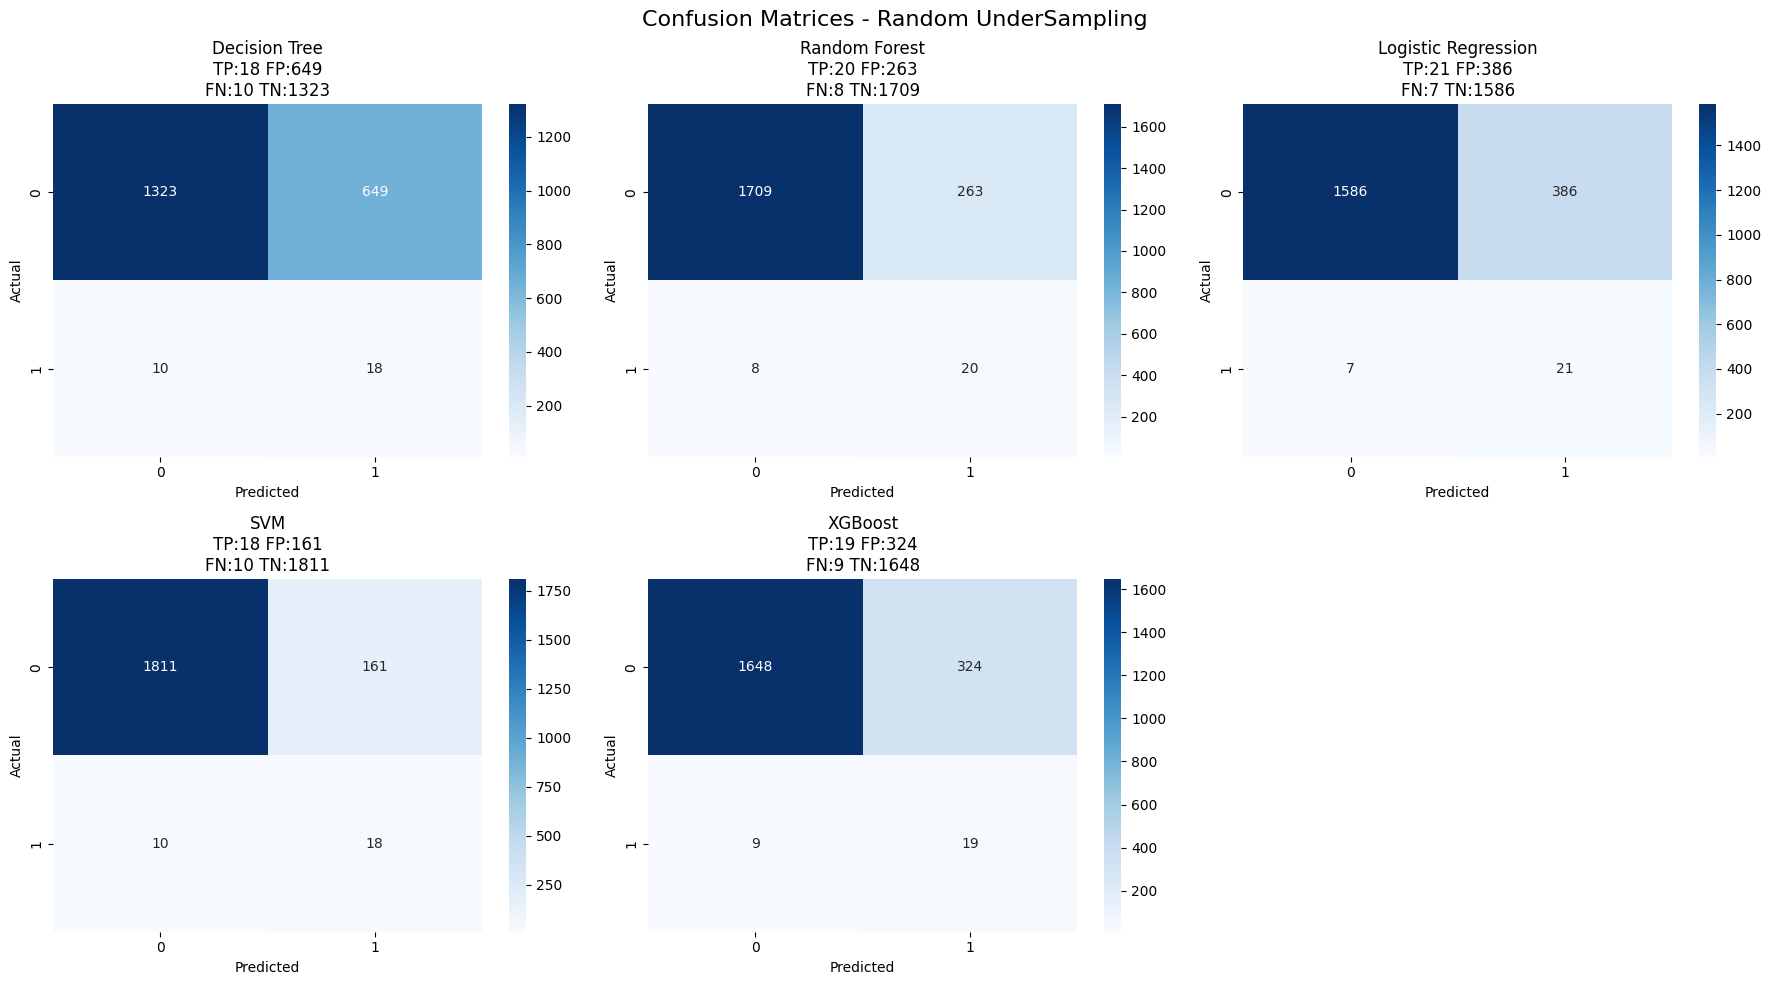

In [21]:
# %%
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Confusion Matrices - Random UnderSampling', fontsize=16)
axes = axes.ravel()

for idx, (model_name, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{model_name}\nTP:{cm[1,1]} FP:{cm[0,1]}\nFN:{cm[1,0]} TN:{cm[0,0]}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

# Hide empty subplot
axes[-1].axis('off')
plt.tight_layout()
plt.show()

In [22]:
# %%
# Save detailed results
results_df.to_csv('random_undersampling_results.csv', index=False)
print("Results saved to 'random_undersampling_results.csv'")

# Display the saved file info
print(f"\nSaved results shape: {results_df.shape}")
print(f"File contains results for {len(results_df)} models")

# Display final summary
print("\nFINAL SUMMARY - Random UnderSampling")
print("=" * 50)
best_f1 = results_df.loc[results_df['F1_Score'].idxmax()]
best_auc = results_df.loc[results_df['ROC_AUC'].idxmax()]
best_cost = results_df.loc[results_df['Cost_Savings'].idxmax()]

print(f"Best F1-Score: {best_f1['Model']} - {best_f1['F1_Score']:.4f}")
print(f"Best ROC AUC: {best_auc['Model']} - {best_auc['ROC_AUC']:.4f}")
print(f"Best Cost Savings: {best_cost['Model']} - ${best_cost['Cost_Savings']:.2f}")

Results saved to 'random_undersampling_results.csv'

Saved results shape: (5, 16)
File contains results for 5 models

FINAL SUMMARY - Random UnderSampling
Best F1-Score: SVM - 0.1739
Best ROC AUC: SVM - 0.8230
Best Cost Savings: SVM - $19.00
